In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.cluster import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler

In [2]:
# data IN
df = pd.read_csv("https://storage.googleapis.com/superlinked-notebook-user-acquisiton-analytics/user_acquisiton_data.csv")

In [3]:
df.info()
df["ad_creative"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           8000 non-null   int64  
 1   signup_date  8000 non-null   int64  
 2   ad_creative  8000 non-null   object 
 3   activity     8000 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 250.1+ KB


Unleash your gaming potential! Upgrade to premium for 2 months free and dominate the competition with XYZCr$$d!                                                  1785
Ready to level up? Join XYZCr$$d now for intense gaming battles and exclusive rewards!                                                                           1312
Embark on your gaming journey with XYZCr$$d! Join now and experience the thrill of competing against the finest players worldwide!                                715
Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!     671
Step into the arena of endless possibilities! Join now to engage in exhilarating gaming competitions and forge friendships with fellow gamers along the way!      541
Calling all gamers! Don't miss out on your chance to excel. Join XYZCr$$d today for unparalleled gaming excitement and endless challenges!                        533
Join

### Vectorizing the text

For the advertisement variable, I used the _all-mpnet-base_ model as the recommended one. I first gathered the 12 unique values for the variable, and created the vectors, then I joined it back to the original dataframe, as running the code on the whole data would take significantly more time and resources.

In [4]:
model = SentenceTransformer("all-mpnet-base-v2")

# collect unique sentences into an array
sentences = df["ad_creative"].unique()

# do the text vectorizing with SentenceTransformer
embeddings = model.encode(sentences)


# merge the embeddings to the sentences, then to the original dataframe
sentences = sentences.reshape(-1, 1)
sentences = np.hstack((sentences, embeddings))

sentences_df = pd.DataFrame(sentences)

df = pd.merge(df, sentences_df,
              left_on = "ad_creative",
              right_on = 0)


### Convert the variables into a meaningful format for clustering

In the data, the signup date and the activity can also be a factor for the clustering algorithm (ID has no relevant information). The features should have similar scaling (as I interpreted my memories, Internet answers and Mór's reply email). To achieve this, this two variables needs to be scaled down to the level of the vectorized variables.

In [5]:
scaler = StandardScaler()

# standardize activity and signup date 
df["activity"] = scaler.fit_transform(df["activity"].values.reshape(-1, 1))
df["signup_date"] = scaler.fit_transform(df["signup_date"].values.reshape(-1, 1))

In [6]:
# remove unnecessary columns
vars = df.drop(["id", "ad_creative", 0], axis = 1)

# HDBSCAN requires the variables to be strings
vars.columns = vars.columns.astype(str)

### Run HDBSCAN clustering

In [7]:
hdb = HDBSCAN(min_cluster_size = 400, min_samples = 15)
hdb_clusters = hdb.fit_predict(vars)
hdb_clusters.max()

6

In [8]:
df["clusters"] = hdb_clusters
df["clusters"].value_counts()

 0    1997
 6    1774
 4    1303
 3    1004
 1     680
 2     526
 5     484
-1     232
Name: clusters, dtype: int64

The clustering algorithm identified 6 clusters (the -1 cluster are the ones the algorithm hasn't categorized).

### UMAP dimension reduction and Plot

In [9]:
umap_transform = umap.UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.1)
umap_data = umap_transform.fit_transform(vars)

# turn the results into a dataframe and add cluster data to points
umap_df = pd.DataFrame(umap_data, columns = ["dimension_1", "dimension_2"])
umap_df["clusters"] = df["clusters"]

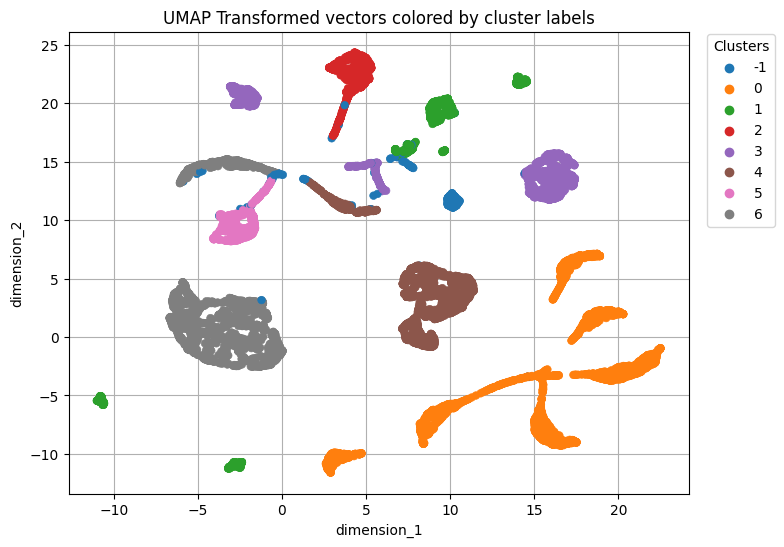

In [10]:
plt.figure(figsize = (8, 6))
ax = sns.scatterplot(data = umap_df, 
                     x = "dimension_1", 
                     y = "dimension_2", 
                     hue = "clusters", 
                     palette = "tab10",
                     edgecolor = None,
                     s = 30,
                     zorder = 2)

plt.title("UMAP Transformed vectors colored by cluster labels")
ax.legend(title = "Clusters", bbox_to_anchor = (1.15, 1.01))
ax.grid(True, zorder = 1)

The dimension reduction and the clustering were not perfect, the hyperparameters should be tuned better. But the code took fairly long on subsequent runs and I didn't see meaningful changes when I tried out new values or parameters. Probably if I knew better these parameters, the resulting plot would look nicer, but it still found the main clusters properly in most of the cases.

Maybe the biggest issue is the -1 cluster (the ones which were not assigned to a cluster), as there are visibly some which should not belong to any cluster, but they are assigned nevertheless. And on the other hand, some points which should be in a cluster are assigned as -1.